# 4th Down Bot

The NYT 4th Down Bot uses NFL play-by-play data to make a recommendation for 4th down decisions.  The current model behind the 4th Down Bot estimates the win probability given a state of the game.  We will do a recreation of the original 4th Down Bot model from Brian Burke (now of ESPN, formerly of Advanced Football Analytics).

The basic premise of the model is to maximize the expected value of the 4th down decision. To do this, we will use NFL play-by-play data to estimate quantities related to the value of a location on the field, punt distance, likelihood of converting a first down, and likelihood of making a field goal.  This notebook builds a replica of the bot.


## The 4th Down Decision Making Model

Our goal will be to maximize the expected value of the decision to go for it, punt, or kick a field goal.  This means we need to compute the following four core models:

1. **Expected Possession Value (EPV):** The value, in points, of a first down at any location on the field.  Kickoffs will also require an expected value.
2. **Expected net punt distance:** Net punt distance given a location on the field.  Coupled with EPV, this quantifies the expected value of punting.
3. **Probability of making a 4th down conversion:** Probability of conversion given a location on the field, eg. how likely a team is to make a 4th and 3 conversion from the opponent 47 yard line.  We can use this with EPV to quantify the expected value of going for the first down.
4. **Field Goal Probability:** Probability of making a field goal from a given distance, eg. how likely it is to make a 45 yard field goal.  Combined with the EPV for field location and kickoffs, we can compute an expected value of kicking the field goal by estimating the likelihood and expected value of a miss or a make.
 
These 4 quantities can be combined to produce expected value of going for the first down, punting, or kicking the field goal.  Our decision rule will be to choose the option that maximizes expected value.  The model we will build is a baseline "average" model that can be used as a starting point before factoring in issues like quality of field goal kicker, offense or defense quality, or weather.


## Tasks

More detail on the individual computations is below.

There are a few code elements to fill in towards the end.  Predominantly there are questions around the modeling process as well as questions about decision making in general at th end.



_References on the 4th Down Bot and 4th down decision making in general_

+ The NYT 4th Down Bot can be found here: http://nyt4thdownbot.com/ 
+ The model: http://www.advancedfootballanalytics.com/index.php/home/research/game-strategy/120-4th-down-study
+ Coverage: http://www.nytimes.com/newsgraphics/2013/11/28/fourth-downs/post.html
+ More coverage: https://www.nytimes.com/2015/10/02/upshot/a-better-4th-down-bot-giving-analysis-before-the-play.html
+ Slides on the construction of the new model: http://slides.com/treycausey/4thdownbot#/
+ The new model on GitHub: https://github.com/TheUpshot/4thdownbot-model
+ Berkeley's own David Romer on 4th down decisions: https://eml.berkeley.edu/~dromer/papers/JPE_April06.pdf



In [1]:
%run ../../utils/notebook_setup.py

Adding datascience helper tools to path...
Setting up Matplotlib...
matplotlib imported as mpl
matplotlib.pyplot imported as plt
seaborn imported as sns


In [2]:
import pandas as pd
import numpy as np

from datascience_stats import curve_fit
from datascience_topic import *

## NFL PxP Data

NFL play-by-play data is available in csv format.  The required data for building the model has already been computed.  See the companion notebooks if you want to know more about how the data was handled to aid this assignment. 

Below is a partial list of the available columns in the full play-by-play dataset.  Many are self explanatory so when needed, a description will be given.  These are the main columns that get used to put together a data analysis.  There are many more fields available that are not used.
+ GameID
+ Drive - index given the # of the drive within the game
+ Quarter
+ Down
+ Yardline100 - the yard line expressed on a scale of 1 to 99 instead of 1 to 50 and back to 1.
+ YardstoGo - yards to go for a first down
+ Yards.Gained - yards gained on the play
+ PossessionTeam - possessing team
+ DefensiveTeam - defensive team
+ PlayType - label for what type of play
+ Touchdown - 0,1 indicating if a TD was scored
+ FieldGoalResult - label indicating good, blocked, or no good.
+ FieldGoalDistance
+ PosTeamScore - Score of the possessing team.  This will flip when the possession flips.
+ DefTeamScore - Score of the defensive team.  This will flip when the possession flips.
+ HomeTeam
+ AwayTeam

A few convenient data fields are added to easy computation of possession value.

+ Half
+ YrdRegion - region of the field: Inside the 10, 10 to 20, and beyond 20.
+ HomeScore & AwayScore - The score of the possession and defensive teams are given.  This changes as the ball changes possession
+ NextPossessionTeam - The team possessing the ball in the next play. Non-plays are ignored
+ NextYardline100 - Where the ball is on the next play. Non-plays are ignored
+ NextDown - The down for the next play
+ 1stDownConversion - Whether the current play converted a first down (0 or 1 value)

In [3]:
pxp = pd.read_csv('data/nfl_pxp_2009_2016.csv.gz', nrows=15)
pxp

,GameID,Drive,Quarter,Down,Time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,Yardline,...,HomeScore,AwayScore,PosScore.onplay,DefScore.onplay,HomeScore.onplay,AwayScore.onplay,NextPossessionTeam,NextYardline100,NextDown,1stDownConversion
0,2009091000,1,1,0,15:00,15,3600.0,0.0,TEN,30.0,...,0.0,0.0,0,0,0,0,PIT,58.0,1.0,1
1,2009091000,1,1,1,14:53,15,3593.0,7.0,PIT,42.0,...,0.0,0.0,0,0,0,0,PIT,53.0,2.0,0
2,2009091000,1,1,2,14:16,15,3556.0,37.0,PIT,47.0,...,0.0,0.0,0,0,0,0,PIT,56.0,3.0,0
3,2009091000,1,1,3,13:35,14,3515.0,41.0,PIT,44.0,...,0.0,0.0,0,0,0,0,PIT,56.0,4.0,0
4,2009091000,1,1,4,13:27,14,3507.0,8.0,PIT,44.0,...,0.0,0.0,0,0,0,0,TEN,98.0,1.0,1
5,2009091000,2,1,1,13:16,14,3496.0,11.0,TEN,2.0,...,0.0,0.0,0,0,0,0,TEN,98.0,2.0,0
6,2009091000,2,1,2,12:40,13,3460.0,36.0,TEN,2.0,...,0.0,0.0,0,0,0,0,TEN,94.0,3.0,0
7,2009091000,2,1,3,12:11,13,3431.0,29.0,TEN,6.0,...,0.0,0.0,0,0,0,0,TEN,96.0,4.0,0
8,2009091000,2,1,4,11:34,12,3394.0,37.0,TEN,4.0,...,0.0,0.0,0,0,0,0,PIT,43.0,1.0,1
9,2009091000,3,1,1,11:24,12,3384.0,10.0,TEN,43.0,...,0.0,0.0,0,0,0,0,PIT,40.0,2.0,0


## Model 1: Expected Possession Value for Kickoffs and First Downs

From the full play-by-play, we need kickoffs and first downs in order to build a possession value calculator.  To do that, this process was used:
1. **Extract kickoffs by using PlayType.**
2. **Extract all first downs**  Drill down by GameID and take all first downs that have 10 yards to go or goal to go.  
3. **Find the next score in the game for each possession.**  This is the hardest computation.  We do this by computing differences in the home and away scores and then fill those backward.  We treat home scores as positive and away scores as negative.  We only consider possession value within a half.  So if there is no score before halftime or the end of the game, the value is 0.   Here is a toy example:
    
| Drive | Team | Poss Score | Next Score |
| ----- | ---- | ---------- | ---------- |
| 1     | Pit  | 0          |   Pit +7   |
| 2     | NYJ  | 0          |   Pit +7   |
| 3     | Pit  | 7          |   Pit +7   |
| 4     | NYJ  | 3          |   NYJ +3   |

4. **Compute possession value.**  We multiply the next score value by +1 or -1 depending on if the current possessing team is the home team or away team.  If its the home team, then multiply by +1 because the next score is already oriented to the home team.  If its the away team, then multiply by -1 because a positive next score is a negative for the away team.
5. **Restrict possessions to the first and third quarter.**

Some caveats:
+ The dataset used is not perfect so while we expect this procedure to work a vast majority of the time, it may miss some results because of holes in the dataset.  It is unlikely this affects the analysis too much.
+ While we restricted to first and third quarters, we did not restrict cases when there is a blowout.  Competitive games lead to more reliable results so this is probably the first issue to address going forward.

The kickoff and first down data can be loaded in `data/nfl_first_downs_2009_2016.csv.gz`.

In [4]:
states_1st_downs_kickoffs = pd.read_csv('data/nfl_first_downs_2009_2016.csv.gz')
states_1st_downs_kickoffs.head(10)

,GameID,Drive,Half,Quarter,Yardline100,YrdRegion,HomeTeam,AwayTeam,PossessionType,PossessionTeam,AbsScoreDiff,NextScore,PossessionValue
0,2009091000,1,1,1,30.0,Beyond20,PIT,TEN,Kickoff,PIT,0.0,7.0,7.0
1,2009091000,1,1,1,58.0,Beyond20,PIT,TEN,FirstDown,PIT,0.0,7.0,7.0
2,2009091000,2,1,1,98.0,Beyond20,PIT,TEN,FirstDown,TEN,0.0,7.0,-7.0
3,2009091000,3,1,1,43.0,Beyond20,PIT,TEN,FirstDown,PIT,0.0,7.0,7.0
4,2009091000,3,1,1,30.0,Beyond20,PIT,TEN,FirstDown,PIT,0.0,7.0,7.0
5,2009091000,4,1,1,89.0,Beyond20,PIT,TEN,FirstDown,TEN,0.0,7.0,-7.0
6,2009091000,4,1,1,42.0,Beyond20,PIT,TEN,FirstDown,TEN,0.0,7.0,-7.0
7,2009091000,4,1,1,22.0,Beyond20,PIT,TEN,FirstDown,TEN,0.0,7.0,-7.0
8,2009091000,5,1,1,73.0,Beyond20,PIT,TEN,FirstDown,PIT,0.0,7.0,7.0
9,2009091000,6,1,1,74.0,Beyond20,PIT,TEN,FirstDown,TEN,0.0,7.0,-7.0


**Questions**

1. Why do we want to only use data from the first and third quarters?  
2. We didn't restrict to non-blowouts situations but how would removing blowouts help clean up the analysis?  
3. In general, why do we remove certain observations from a dataset?

**Answers**

### A. Expected Kickoff Value

In the dataset, the return team is considered the possessing team.  So computing the average value represents the expected value to the return team.

After this, `ekv` contains our model for Expected Kickoff Value.

In [5]:
# Restrict to kickoff events
kickoff_mask = states_1st_downs_kickoffs['PossessionType'] == 'Kickoff'
kickoffs = states_1st_downs_kickoffs.loc[kickoff_mask]

# Compute the average kickoff value
ekv = kickoffs['PossessionValue'].mean()
print(f"Expected Kickoff Value: {ekv:.3f} pts")

Expected Kickoff Value: 0.599 pts


### B. Expected Possession Value 

We group by each yard line, excluding kickoffs, and compute the average possession value.

The plot below shows the results of our estimation.  We clearly see a strong relationship between the Raw Expected Possession Value but the noise in the estimation is apparent.  The expected value should be "smooth" and increasing as you get closer and not fluctuating so much.

In [6]:
first_downs = states_1st_downs_kickoffs.loc[~kickoff_mask]

In [7]:
# 1. Ignore kickoffs
# 2. Group by yardline 
# 3. Take the average of PossessionValue
epv = first_downs.\
    groupby('Yardline100').\
    agg({'PossessionValue': np.mean})

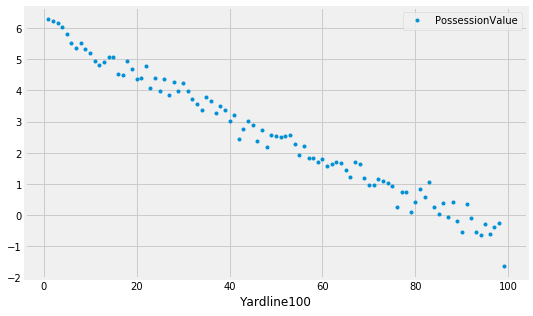

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
epv.plot(ax=ax, linestyle='', marker='.')
ax.grid(True)

### C. Smoothed Expected Possession Value Model


#### Model Smoothing

Suppose we have data that is noisy but we know the underlying model should be smooth.  We can do some basic curve fitting, or _smoothing_, to clean up the data and give us something nice.  The next cell shows a simple example of this using the provided function `curve_fit`.  The parameter `smoothness` controls how smooth the output is.  Feel free to vary the parameter to see how the output changes.

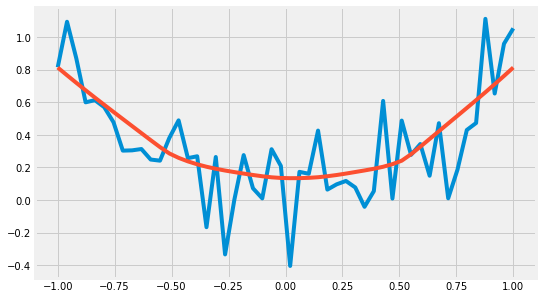

In [9]:
x = np.linspace(-1, 1)
y = x**2 + .2 * np.random.randn(len(x)) # y is a noisy parabola

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, y);

y_smooth = curve_fit(x, y, smoothness=.5)
ax.plot(x, y_smooth);

#### Smoothing Expected Possession Value

We can now use the curve fitting to produce a "smoothed" estimate of the Expected Possession Value.

After this, `epv_model` contains our model for Expected Possession Value for a location on the field.

In [10]:
yardlines = epv.index
poss_vals = epv['PossessionValue']

# create the smoothed EPV values using a custom smoothness value
epv_values = curve_fit(yardlines, poss_vals, smoothness=.22)
# create the EPV model
epv_model = pd.Series(data=epv_values, index=yardlines)

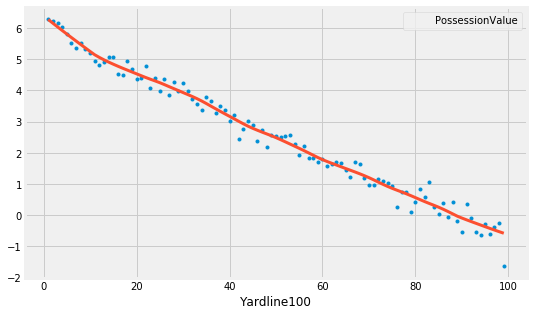

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
epv.plot(ax=ax, linestyle='', marker='.')
epv_model.plot(ax=ax, lw=3);

**Questions**

1. Around the 10 yard line (90 in Yardline100), the expected value is 0.  What does this mean?
2. What is the significance of the slope of the line?  What are its units?
3. There appears to be an elbow in the curve around the opponent 10 yard line (10 in Yardline100).  This is where first downs go from 10 yards to go to goal to go.  Can you provide a possible reason for this increase in the rate of EPV?
4. Consider two hypothetical alternative models for expected point:
    + The line goes from left to right from +6 to +5 (much less steep than the actual model).  
    + The line goes from +6 to -6 and passes 0 at the 50 yard line (much steeper than the actual model).

   What would you conclude about possession and scoring in these two hypothetical situations?


**Answers**

## Model 2: Net Punt Distance

We need net punt distance.  Extracting punts from the full play-by-play is easy (there's a playtype flag).  Determining net punt distance is tricky.  A few things can happen on a punt: 
+ It goes off as expected
+ Returned for a touchdown
+ Muffed
+ Fumbled
+ Blocked.  

There may be even more wrinkles.  Suffice to say, this is a bit complicated.  To simplify things, we just want to know the expected net punt distance for punts that are not returned, muffed, fumbled, blocked, or anything else.  

We compute net punt distance by finding regular punts and determining the field position change.

In [12]:
punts = pd.read_csv('data/nfl_punts_2009_2016.csv')
punts.head()

,GameID,HomeTeam,AwayTeam,Drive,Half,Quarter,Down,PossessionTeam,Yardline100,YrdRegion,PlayType,NetPuntDist
0,2009091000,PIT,TEN,1,1,1,4,PIT,56.0,Beyond20,Punt,54.0
1,2009091000,PIT,TEN,2,1,1,4,TEN,96.0,Beyond20,Punt,39.0
2,2009091000,PIT,TEN,3,1,1,4,PIT,41.0,Beyond20,Punt,30.0
3,2009091000,PIT,TEN,5,1,1,4,PIT,79.0,Beyond20,Punt,53.0
4,2009091000,PIT,TEN,8,1,2,4,TEN,44.0,Beyond20,Punt,39.0


**Question**

1. Why is it okay to simplify things?  To assist in reasoning out your response, it's helpful to know that in 2017 NFL teams averages 1 punt return TD per 100 punt return attempts.  The key question of whether it's okay to simplify things is this: By about how many points in expectation does ignoring punt return TDs change the result?

**Answer**

### A. Net Punt Distance

To compute net punt distance, we consider all the "successful" punts we extracted (ie. ignoring return TDs, muffs, and fumbles, etc).  In building the punts table, we look at the current yardline and the next yardline and computed a difference (accounting for the switch in orientation of the 100 yard value) to get net punt distance.  Now we just need to average.

In the plot below, we see a beautiful relationship between expected punt distance and the yardline.  As with Expected Possession Value, the expected net punt distance should be increasing as you get closer and not fluctuating as much.

In [13]:
# 1. Group by yardline
# 2. Take the average of net_punt_len (the average automatically ignores null values!)
raw_punt_dist = punts.\
    groupby('Yardline100').\
    agg({'NetPuntDist': np.mean})
raw_punt_dist.head(20)

,NetPuntDist
Yardline100,
29.0,18.500
30.0,21.000
31.0,26.000
32.0,19.364
33.0,17.846
34.0,19.583
35.0,22.500
36.0,25.575
37.0,25.373


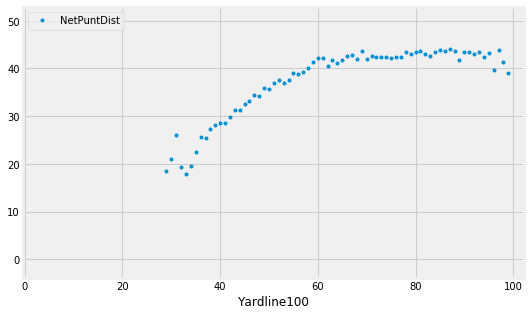

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
raw_punt_dist.plot(ax=ax, linestyle='', marker='.')
ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2);

### C. Smoothed Net Punt Distance

We can run our curve fit to generate a final model.  We clearly require this since we do not want a straight line for Expected Net Punt Distance.

`punt_dist_model` will contain our model for Expected Net Punt Distance.

In [15]:
yards = raw_punt_dist.index
punt_dist = raw_punt_dist['NetPuntDist']

# use the default smoothness parameter
xpunt_dist = curve_fit(yards, punt_dist)

# Convert to integer values (this will be needed later)
xpunt_dist = np.round(xpunt_dist).astype(int)
punt_dist_model = pd.Series(
    data=xpunt_dist,
    index=yards,
    name='Expected Net Punt Dist'
)

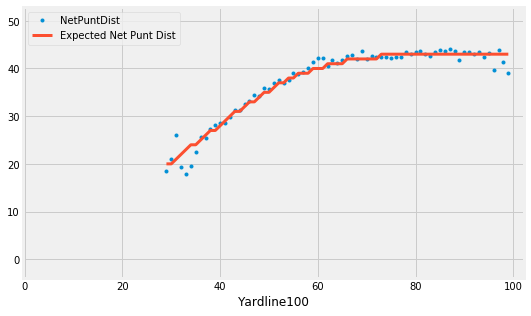

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

raw_punt_dist.plot(ax=ax, ls='', marker='.')
punt_dist_model.plot(ax=ax, lw=3)

ax.set_xlim(-.3, 102.3)
ax.set_ylim(-4, 53)
ax.legend(loc=2);

**Question**
1. Without redoing everything, what is one way you could tweak the model to account for the quality of the punter or the quality of the punt coverage by the punting team?

**Answer**

## Model 3: 1st Down Conversion Probability


In football, teams typically treat third down as do or die.  Hence, we are going to use third down conversion percentage as a proxy for 4th down conversion percentage.  You shouldn't have a hard time convincing yourself why it make sense to approximate the conversion percentage using 3rd down data instead of 4th down data.

There are some things we need to address.  In the dataset, various non-relevant plays can occur on third down.  We need to ignore these.  Also, we can likely safely assume that beyond 9 yards we do not need to consider going for it.

In [17]:
third_downs = pd.read_csv('data/nfl_third_downs_2009_2016.csv')
third_downs.head()

,GameID,HomeTeam,AwayTeam,Drive,Half,Quarter,Down,PossessionTeam,Yardline100,YrdRegion,YardstoGo,PlayType,1stDownConversion
0,2009091000,PIT,TEN,1,1,1,3,PIT,56.0,Beyond20,8,Pass,0
1,2009091000,PIT,TEN,2,1,1,3,TEN,94.0,Beyond20,6,Run,0
2,2009091000,PIT,TEN,3,1,1,3,PIT,22.0,Beyond20,2,Sack,0
3,2009091000,PIT,TEN,4,1,1,3,TEN,19.0,10to20,7,Pass,0
4,2009091000,PIT,TEN,5,1,1,3,PIT,70.0,Beyond20,7,Sack,0


### A. Expected Conversion Percentage

#### Conversion Percentage by Region

We each separate region on the field (inside the 10 yardline, from the 10 yardline to the 20 yardline, and beyond the 20 yardline), and compute the expected conversion percentage for each yard to go value.  We separate into regions because we have reason to believe that near the goalline, the offense is less likely to convert given less room to work with.  The data bears this out.  This change in conversion percentage can affect the expected value quantities.

As with possession value, we need to smooth out the values since they should be consistent as the yards change incrementally.

In [18]:
# 1. Group by region and yards to go
# 2. Take the average success rate
raw_conv_pct = third_downs.\
    groupby(['YrdRegion', 'YardstoGo']).\
    agg({'1stDownConversion': np.mean}).\
    unstack(level=0)  # unstack the table so the regions are columns

# clean up the columns
raw_conv_pct.columns = raw_conv_pct.columns.droplevel()
raw_conv_pct = raw_conv_pct[['Beyond20', '10to20', 'Inside10']]
raw_conv_pct

YrdRegion,Beyond20,10to20,Inside10
YardstoGo,,,
1,0.695,0.670,0.605
2,0.592,0.580,0.492
3,0.548,0.495,0.455
4,0.518,0.472,0.375
5,0.494,0.417,0.421
6,0.448,0.447,0.312
7,0.434,0.392,0.375
8,0.407,0.311,0.347
9,0.354,0.271,0.254


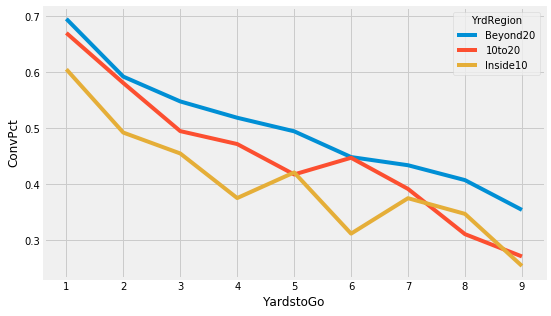

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
raw_conv_pct.plot(ax=ax)
ax.set_xlabel('YardstoGo')
ax.set_ylabel('ConvPct');

### B. Smoothed Expected Conversion Percentage

We'll use the curve fitting again to smooth out our Expected Conversion Percentage.

Our final model for Expected Conversion Percentage will be in `conv_pct_model`.

In [20]:
conv_pct_model = raw_conv_pct.copy()
yards_to_go = conv_pct_model.index

# Create the smoothed model for each region of the field
for region in ['Inside10', '10to20', 'Beyond20']:
    conv_pct_region = raw_conv_pct[region]
    # use the default smoothness parameter
    fitted_vals = curve_fit(yards_to_go, conv_pct_region)
    conv_pct_model[region] = fitted_vals

conv_pct_model

YrdRegion,Beyond20,10to20,Inside10
YardstoGo,,,
1,0.693,0.669,0.596
2,0.619,0.581,0.514
3,0.549,0.516,0.443
4,0.520,0.466,0.411
5,0.488,0.444,0.377
6,0.458,0.417,0.365
7,0.431,0.387,0.350
8,0.399,0.323,0.328
9,0.357,0.267,0.262


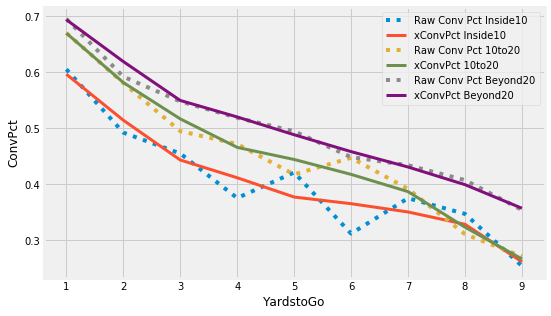

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

for region in ['Inside10', '10to20', 'Beyond20']:
    # plot the raw conversion percentage
    raw_conv_pct[region].plot(
        ax=ax, ls=':', label='Raw Conv Pct ' + region)
    
    # plot the model conversion percentage
    conv_pct_model[region].plot(
        ax=ax, lw=3, label='xConvPct ' + region)

ax.legend(loc=1)
ax.set_ylabel('ConvPct');

**Questions**

1. What is the likely reason that it makes a difference in conversion percentage where on the field the ball is?  For example, do you think it is easier or harder to convert a third down at your own 30 yard line versus at your opponent's 7 yard line?
2. The change in conversion percentage is about 10% between the middle of the field and inside the 10 yard line.  How large of an effect is this?

**Answers**

## Model 4: Field Goal Probability

We gather field goal results and compute the expected probability of success.

Raw field goal probability is a bit noisy as we have grown accustom to seeing so far.  We fit a curve but this time we ignore data observations beyond 63 yards since they are extra noisy.

### Field Goals

For field goal results, we just need FieldGoalDistance and FieldGoalResult and then to compute a 0-1 value representing the success.  This is straightforward.

In [22]:
fgs = pd.read_csv('data/nfl_fgs_2009_2016.csv')
fgs.head()

,FieldGoalDistance,FieldGoalResult,FieldGoalSuccess
0,37.0,No Good,0
1,31.0,Blocked,0
2,45.0,Good,1
3,32.0,Good,1
4,33.0,Good,1


### A. Field Goal Probability

In [23]:
# 1. Group by distance 
# 2. Take the average success rate
raw_fg_prob = fgs.\
    groupby('FieldGoalDistance').\
    agg({'FieldGoalSuccess': np.mean})
raw_fg_prob.head(20)

,FieldGoalSuccess
FieldGoalDistance,
18.0,1.000
19.0,1.000
20.0,0.994
21.0,0.970
22.0,0.978
23.0,0.983
24.0,0.934
25.0,0.991
26.0,0.962


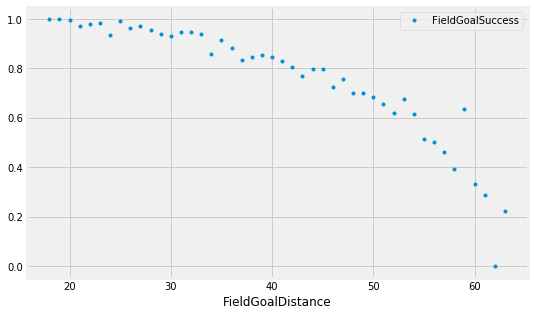

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
raw_fg_prob.plot(ax=ax, linestyle='', marker='.');

### B. Smoothed Field Goal Probability

We can run another curve fit to get a nice estimate of field goal probability.

`fg_prob_model` will contain our field goal probability model.

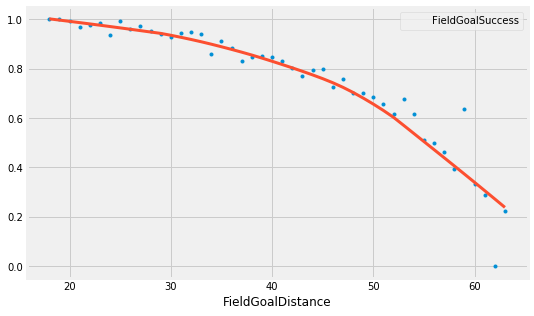

In [25]:
fg_yards = raw_fg_prob.index

# use the default smoothness parameter
fg_prob_values = curve_fit(fg_yards, raw_fg_prob['FieldGoalSuccess'])
# build the FG model
fg_prob_model = pd.Series(data=fg_prob_values, index=fg_yards)

fig, ax = plt.subplots(figsize=(8, 5))
raw_fg_prob.plot(ax=ax, ls='', marker='.')
fg_prob_model.plot(ax=ax, lw=3);

**Question**

1. We are computing a baseline "average" model that can be used as a starting point.  Obviously the quality of the kicker and the field/weather conditions are incredibly important to kicking.  Similar to the punt model, how would you adjust our model to account for these considerations?

**Answer**

## Decision Making

Let's put the models to work

### Extracting Model Values

First, let's show how we can extract outputs from the model based on a hypothetical situation.

It's 4th and 4 from the opponent's 42 yard line (this means `Yardline100` is 42).  What are the model outputs?

In [26]:
yardline100 = 42
region = 'Beyond20'
ydstogo = 4
fg_distance = yardline100 + 17

# Model values can be extracted easily
print(f"EPV at opponent 42 yardline: {epv_model[yardline100]:.2f}")
print(f"Exp Conv Pct beyond the 20 with 4 yards to go: {conv_pct_model[region][ydstogo]:.2f}")
print(f"Exp Net Punt Dist from the 42: {punt_dist_model[yardline100]:.2f}")
print(f"Exp FG Pct from 45 yards: {fg_prob_model[fg_distance]:.2f}")

EPV at opponent 42 yardline: 3.01
Exp Conv Pct beyond the 20 with 4 yards to go: 0.52
Exp Net Punt Dist from the 42: 30.00
Exp FG Pct from 45 yards: 0.37


#### TO DO: Another Model Value Example

It's 4th and 1 from the opponent's 2 yard line.  What are the model outputs?  Note: Is the punt model valid here?

In [27]:
yardline100 = 2
region = 'Inside10'
ydstogo = 1
fg_distance = yardline100 + 17

# Model values can be extracted easily
print(f"EPV at opponent 42 yardline: {epv_model[yardline100]:.2f}")
print(f"Exp Conv Pct beyond the 20 with 4 yards to go: {conv_pct_model[region][ydstogo]:.2f}")
# print(f"Exp Net Punt Dist from the 42: {punt_dist_model[yardline100]:.2f}")
print(f"Exp FG Pct from 45 yards: {fg_prob_model[fg_distance]:.2f}")

EPV at opponent 42 yardline: 6.16
Exp Conv Pct beyond the 20 with 4 yards to go: 0.60
Exp FG Pct from 45 yards: 1.00


### Expected Value of our Decisions

It's 4th and 1 from the opponent's 35 yard line.  What should we do?

In [28]:
yardline100 = 35
region = 'Beyond20'
ydstogo = 1
fg_distance = yardline100 + 17

#### TO DO: Expected value of going for it
1. First determine the value of a successful conversion.  Here are the rules for determining this value:
    + If the situation **is not** goal to go,  get the EPV of the yardline at the spot of the conversion.  Assume the down is converted with the smalled possible number of yards, ie. the yards to go.  So if it's 4th and 4 at the 42, the first down as at the 38.
    + If the situation **is** goal to go, then a 1st down conversion is a TD so take 7 minus the value of a kickoff.
2. Then determine the value of a failed conversion
    + Assume the conversion fails at the current yardline (not yards gained or lost on the failure).
    + Find the starting yardline for the opposing team by taking 100 minus the current yardline
    + Get the EPV for this starting position and multiply by -1 to get the value for _our team_ and not the opposing team.
3. Finally, compute the expected value using the conversion success probability
    + Weight the above expected values by the conversion success probability based on the region of the field

In [29]:
conv_line = yardline100 - ydstogo
ev_success = epv_model[conv_line]

fail_line = 100 - yardline100
ev_failure = -epv_model[fail_line]

p_conv_success = conv_pct_model[region][ydstogo]

# ev_goforit = ...
ev_goforit = p_conv_success * ev_success + (1 - p_conv_success) * ev_failure
ev_goforit  # 2.0800749018024116

2.0800749018024116

#### TO DO:  Expected value of punting
1. Determine the expected net punt distance from the model.
2. Compute the expected value of the expected yardline after the punt
    + The expected yardline following the punt is the current yardline minus the expected punt distance.  So if we're at our own 30 yardline (Yardline100 = 70) and the punt distance is 42 yards, the expected yardline is 28.
    + Find the starting yardline for the opposing team by taking 100 minus the expected yardline after the punt
    + Get the EPV for the expected starting position and multiply by -1 to get the value for our team.

In [30]:
xpunt_dist = punt_dist_model[yardline100]
xyardline = yardline100 - xpunt_dist
opp_start_line = 100 - xyardline

ev_punt = -epv_model[opp_start_line]
ev_punt  # 0.03172564552047145

0.03172564552047145

#### TO DO:  Expected value of kicking
1. Compute the value of making the field goal: 3 minus the value of a kickoff, which is given by `ekv`.
2. Compute the value of missing the field goal.
    + Missing the kick means the ball is turned over at Yardline100 + 7
    + The starting position for the opposing team is 100 minus (Yardline100 + 7)
    + Get the EPV for the starting position
3. Compute the expected value using the field goal success probability
    + The kick distance is given by Yardline100 + 17
    + Use the kick distance to get the field goal success probability
    + Weight the two values in 1. and 2. by the field goal success probability

In [31]:
ev_fg_success = 3 - ekv

fg_yardline = yardline100 + 7
opp_start_line = 100 - xyardline
ev_fg_failure = -epv_model[opp_start_line]

fg_distance = yardline100 + 17
p_fg_success = fg_prob_model[fg_distance]

ev_fg = p_fg_success * ev_fg_success + (1 - p_fg_success) * ev_fg_failure
ev_fg  # 1.4585321486335627

1.4585321486335627

#### Decision

We can print out the three expected values. 

You should get this:
```
EV going for it: 2.08
EV punting:      0.03
EV field goal:   1.46
```

In [32]:
print(f"EV going for it: {ev_goforåit:.2f}")
print(f"EV punting:      {ev_punt:.2f}")
print(f"EV field goal:   {ev_fg:.2f}")

NameError: name 'ev_goforåit' is not defined

**Questions**

1. Which choice would you make?  Why?  What else would go into your decision?
2. How much extra is the decision worth in expected points?

**Answers**

## Visualizing Decisions

We can use a helper function which iterates over all the yardline and yards-to-go combinations to compute the decisions.

The function computes the following:
+ The best choice 
+ The expected value of the best choice
+ The second best choice
+ The _difference_ in expected value of the best choice over the second best choice

In [ ]:
data = compute_4thdownbot_data(ekv, epv_model, conv_pct_model, punt_dist_model, fg_prob_model)

yrdline100 = 20
yrdstogo = 5
print(data[yrdstogo][yrdline100])

### 4th Down Bot Decisions

We use a helper function to visualize the decision space.

In [ ]:
plot_4thdown_decision(data)

**Question**
1. If we just show the best decision choices, what are we missing in terms of information?  What else would you want to know regarding making any decisions?

**Answer**

### Second Choices

We can also look at the second best choices.

In [ ]:
plot_4thdown_second_choices(data)

**Question**
1. What appears to happen around the 37-38 yard line with respect to punting and kicking a field goal?

**Answer**

### Expected Values

It would be useful to know how many points we expect when making our decision.

In [ ]:
plot_4thdown_evs(data)

### Expected Value over Second Choice

Even more useful would be to know how many more points our top choice is worth relative to the next best choice.

In [ ]:
plot_4thdown_ev_over_second(data)

**Questions**
1. What is the significance of the bright yellow region around the 38 yard line?  What is it telling us about punting or kicking a field goal relative to trying to hold onto possession?
2. There is a huge region over which the 4th Down Bot says to go for it.  Does the increase in expected value from going for it seem particularly large over most of that region?

**Answers**

### Coaches' Choices

![coaches_decisions](coach_decisions.png "Coaches Decisions")

Compare the 4th Down Bot's decisions with the actual coaches decisions (courtesy of the NYT).  

**Question**
1. How does the previous plot showing the expected value over the second choice compare to the coaches' choices?

## Wrap Up

This notebook went over step by step how to piece together components using historical NFL play-by-play data to build a decision making 4th Down Bot.  The expected value analysis is very useful for beginning to think in a data-driven way.  Wrapping up, we finish with some general questions about expected value analysis and some considerations we might want to make.

In finance, there is a concept called _risk premium_ which refers to how much more return we demand for taking a riskier stock compared to a less risky stock.  That is, just because an stock has higher return, we will not necessarily take it due to the potential increase in risk.

Here's a simple example:  consider a game show where you may choose one of two doors which are hiding $\$$1,000 and $\$$0. Suppose I offer you $\$$500 instead of choosing a door.  Would you take the $\$$500 or choose a door?

The risk in this situation is the uncertainty of the payout and the possibility of ending up with $\$$0.  If you are unconcerned with risk, you view those options as equivalent.  If you are risk averse, you will opt for the $\$$500.  And if you are risk loving (ie. you derive benefit or utility or joy or something from taking risk) you will gamble on a door.

There is an amount called the _certainty equivalent_ where you would view that amount as equal to the gamble.  Since the expected value of the gamble is $\$$500, if you are risk averse the certainty equivalent is less than $\$$500.  It is the point at which below that amount you'd prefer the gamble and above that amount you'd prefer the certain payout.  Each person will have their own certainty equivalent.

The difference between the certainty equivalent and the expected value of the gamble is the risk premium.

The game show Deal or No Deal is an example of offering certainty amounts against gambles on large payouts.

**Questions**
1. How does punting represent a "certain" choice (or at least a less risky choice)?  
2. How does maximizing expected value ignore the risk in the decision?
   
   Consider this situation: we're on our own 10 yard line and its 4th and short.
   Some numbers for 4th and 1 from your own 10 yard line:
    + The expected value after conversion is about -0.09 points
    + The expected value after a failed conversion is -5.25 points
    + The conversion percentage is 69% so the overall expected value of going for it is -1.6
    + The expected value from punting is -2.3, .7 points lower than going for it.
   
   Overall, the EV for going for it is better.  But the downside of the failed conversion is high.  Is going for it a very risky decision based on those numbers?
   
4. Does maximizing expected points make sense throughout the game?  What about at the end of the game?


_Win Probability_

One possible alternative is to build a model for win probability given a game state.  The new NYT 4th Down Bot model does just this.  Using the win probability computation, a coach would make decisions that maximize win probability instead.  We saw something like this for bunting and stolen bases. 

Think of the classic Belichick choice against the Colts: go for it on 4th and short in your own territory at the end. [See here](https://fifthdown.blogs.nytimes.com/2009/11/16/defending-belichicks-fourth-down-decision/)

Here are some toy numbers.  Say it's 50-50 whether you make the conversion.  If you do make the conversion, you get a 100% win probability.  If you don't, you turn it over to Peyton Manning in his prime and now have a 20% win probability.  If you punt, you give the ball to Manning and its 60-40 in your favor.  Overall you have 60% win probability in each case.  
    
5. Does risk aversion still play a role when thinking about win probability?

_Ambiguity Aversion_

Risk averse people don't want to take risky bets even if they know the odds.  _Ambuigity averse_ people don't want to take bets they don't know the odds to  ([See here for an overview of ambiguity aversion](https://en.wikipedia.org/wiki/Ambiguity_aversion)).

So far, we've been quoting static numbers from models to build all our decisions.  We haven't pinned down how reliable or uncertain our models are.  

Let's reconsider Belichick's dilemma from 5.  We made up some numbers but they're not far off numbers other people have suggested.  So let's take our numbers as the output of the models.  An important question is how sure can we be these numbers are correct?  If the numbers aren't correct, do we want to take the gamble of going for it?  If we feel there is a lot of uncertainty in the model's output, we might be averse to this ambiguity and avoid taking the gamble.

6. How might a coach's decisions stem from both risk aversion and ambiguity aversion?
    
**Answers**